In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier

In [4]:
RANDOM_SEED = 0  # set random seed for all randomness

EXIST_PATH = '/content/exists_climate.csv'  # path for exist data set
DNE_PATH = '/content/DNE_climate.csv'  # path for DNE data set

MAX_DEPTH_LIST = range(2, 21)  # different values of max_depth
CRITIERIA_LIST = ["entropy", "gini"]  # different split critieria


In [5]:
# 5(a)
def load_data():
  """
  Load data from csv files and split the entire dataset randomly into 
  70% training, 15% validation, and 15% test examples. 
  """
  # load cleaned data from csv files
  exist_data = pd.read_csv(EXIST_PATH)
  DNE_data = pd.read_csv(DNE_PATH)  

  # add labels
  exist_data['label'] = "exists"
  DNE_data['label'] = "DNE"

  # concat exist and DNE into one data set
  climate_data = pd.concat([exist_data, DNE_data], ignore_index=True)

  # Convert a text in column "tweet" to a matrix of token counts
  vectorizer = CountVectorizer()
  token_tweet = vectorizer.fit_transform(climate_data["tweet"])

  # transer to array and merge the token data with original data set
  token_data = pd.DataFrame(token_tweet.toarray(), columns=vectorizer.get_feature_names_out())
  merged_data = pd.concat([climate_data, token_data], axis=1)  # concat along columns

  # split data
  input = merged_data.iloc[:, 2:]  # all rows and all token columns
  target = merged_data.iloc[:, 1]  # all rows and the label column
  # split into 70% training and 30% validation and test examples first
  train_input, val_test_input, train_target, val_test_target = train_test_split(input, target, train_size=0.7, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
  # split into 15% validation, and 15% test examples
  val_input, test_input, val_target, test_target = train_test_split(val_test_input, val_test_target, train_size=0.5, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

  # return tarining, validation and test examples
  return train_input, train_target, val_input, val_target, test_input, test_target, vectorizer

In [6]:
def select_tree_model(train_input, train_target, val_input, val_target):
  """
  Train the decision tree classifier using different max_depth and different split criteria.
  Evaluate the performance of each one on the validation set, 
  and print the resulting accuracies of each model.
  """
  accuracy_list = []
  model_list = []
  
  # construct decision trees for each criterion and max_depth
  for criterion in CRITIERIA_LIST:
    for max_depth in MAX_DEPTH_LIST:
      dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=RANDOM_SEED) 
      dt.fit(train_input, train_target)
      model_list.append(dt)
      # prediction on valudation examples
      prediction = dt.predict(val_input)
      accuracy = sum(prediction == val_target) / len(val_target)
      accuracy_list.append(accuracy)
      print(f"Validation accuracy with max_depth {dt.max_depth} and criterion {dt.criterion}: {accuracy}")
  
  # return and print the best model with the highest validation accuracy
  best_tree = model_list[accuracy_list.index(max(accuracy_list))]
  print(f"The best model is the decision tree with max_depth {best_tree.max_depth}, criterion {best_tree.criterion} and accuracy: {max(accuracy_list)}")
  return best_tree

In [10]:
def test_and_visualize(best_val_model, test_input, test_target, vectorizer):
  """
  Input the best model with the highest validation accuracy.
  Report its accuracy on the test dataset. Moreover, 
  extract and visualize the first two layers of the tree.
  """
  # prediction on test examples
  prediction = best_val_model.predict(test_input)
  accuracy = sum(prediction == test_target) / len(test_target)
  print(f"The test accuracy of the best model: {accuracy}")

  # visualize the first two layers
  fig = plt.figure(figsize = (15,10))
  tree.plot_tree(best_val_model, max_depth=2, feature_names=vectorizer.get_feature_names_out())
  plt.show()

In [8]:
# 5(b) Evaluate the performance of each model on the validation set, and prints the resulting accuracies.
train_input, train_target, val_input, val_target, test_input, test_target, vectorizer = load_data()
best_val_model = select_tree_model(train_input, train_target, val_input, val_target)

Validation accuracy with max_depth 2 and criterion entropy: 0.7611464968152867
Validation accuracy with max_depth 3 and criterion entropy: 0.7611464968152867
Validation accuracy with max_depth 4 and criterion entropy: 0.767515923566879
Validation accuracy with max_depth 5 and criterion entropy: 0.7722929936305732
Validation accuracy with max_depth 6 and criterion entropy: 0.7770700636942676
Validation accuracy with max_depth 7 and criterion entropy: 0.7834394904458599
Validation accuracy with max_depth 8 and criterion entropy: 0.785031847133758
Validation accuracy with max_depth 9 and criterion entropy: 0.7834394904458599
Validation accuracy with max_depth 10 and criterion entropy: 0.785031847133758
Validation accuracy with max_depth 11 and criterion entropy: 0.7882165605095541
Validation accuracy with max_depth 12 and criterion entropy: 0.7961783439490446
Validation accuracy with max_depth 13 and criterion entropy: 0.7977707006369427
Validation accuracy with max_depth 14 and criterion

The test accuracy of the best model: 0.78060413354531


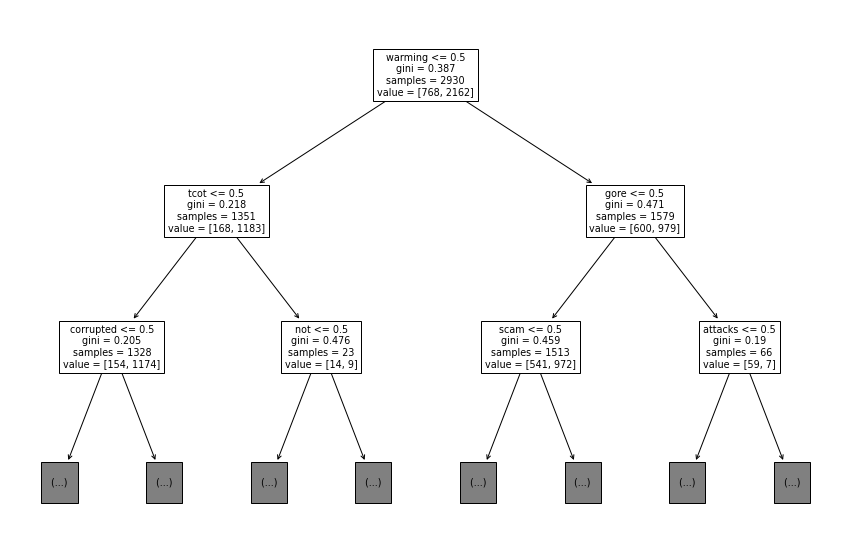

In [11]:
# 5(c) Test accuracy of the best model and visualize its first two layers. 
test_and_visualize(best_val_model, test_input, test_target, vectorizer)

In [12]:
def compute_information_gain(train_input, train_target, vectorizer, word_list):
  """
  Compute the information gain of a split on the training data.
  """
  IG_list = list(zip(vectorizer.get_feature_names_out(), mutual_info_classif(train_input, train_target)))
  for feature in IG_list:
    # print(feature)
    if feature[0] in word_list:
      print(feature)

In [14]:
# 5(d)
words =  ['warming','tcot','gore', 'scam', 'attacks', 'snow','fraud']
compute_information_gain(train_input, train_target, vectorizer, words)

('attacks', 0.008625979091950953)
('fraud', 0.01505510009951938)
('gore', 0.02813186170258075)
('scam', 0.012411796856010016)
('snow', 0.012660404534423852)
('tcot', 0.005028414631297329)
('warming', 0.04899454770722378)


In [15]:
def select_knn_model(train_input, train_target, val_input, val_target, test_input, test_target):
  k_values = range(1, 21)

  # Compute both training and validation errors for 20 KNN models.
  train_errors = []
  val_errors = []
  val_accuracies = []
  model_list = []
  for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_input, train_target)
    model_list.append(knn)

    train_prediction = knn.predict(train_input)
    val_prediction = knn.predict(val_input)
    train_error = np.mean(train_prediction != train_target)
    train_errors.append(train_error)
    val_error = np.mean(val_prediction != val_target)
    val_errors.append(val_error)
    val_accuracies.append(np.mean(val_prediction == val_target))

    print(f"KNN model with k = {knn.n_neighbors} having training error: {train_error} and validation error: {val_error}")

  # Generate a graph of training and validation error VS k.
  plt.plot(k_values, train_errors[::-1], color='orange', marker='o', label="Training")
  plt.plot(k_values, val_errors[::-1], color='blue', marker='o', label="Validation")
  plt.xticks(k_values, labels=k_values[::-1])
  plt.ylim((0, 0.3))
  plt.xlabel("k - Number of Nearest Neighbors") 
  plt.ylabel("Error")
  plt.title('Training and validation errors for different k values')
  plt.legend()
  plt.show()
  
  # Find the model with the best validatoin accuracy.
  best_model = model_list[val_accuracies.index(max(val_accuracies))]
  print(f"The best KNN model with k = {best_model.n_neighbors} having validation accuracy: {max(val_accuracies)}")

  # Report its accuracy on the test data.
  test_prediction = best_model.predict(test_input)
  test_accuracy = np.mean(test_prediction == test_target)
  print(f"The best KNN model with k = {best_model.n_neighbors} having test accuracy: {test_accuracy}")


KNN model with k = 1 having training error: 0.0034129692832764505 and validation error: 0.20222929936305734
KNN model with k = 2 having training error: 0.11160409556313994 and validation error: 0.27229299363057324
KNN model with k = 3 having training error: 0.10068259385665529 and validation error: 0.19904458598726116
KNN model with k = 4 having training error: 0.157679180887372 and validation error: 0.25796178343949044
KNN model with k = 5 having training error: 0.1416382252559727 and validation error: 0.2070063694267516
KNN model with k = 6 having training error: 0.15802047781569967 and validation error: 0.22452229299363058
KNN model with k = 7 having training error: 0.16518771331058021 and validation error: 0.2229299363057325
KNN model with k = 8 having training error: 0.1597269624573379 and validation error: 0.2085987261146497
KNN model with k = 9 having training error: 0.17337883959044367 and validation error: 0.20222929936305734
KNN model with k = 10 having training error: 0.1713

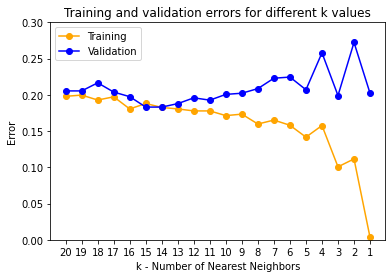

The best KNN model with k = 14 having validation accuracy: 0.8168789808917197
The best KNN model with k = 14 having test accuracy: 0.739268680445151


In [16]:
# 5(e)
select_knn_model(train_input, train_target, val_input, val_target, test_input, test_target)